In [2]:
colab=False    
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    chdir('/content/drive/MyDrive/BI - Data/')
    
!git clone https://github.com/dinaghiassian/DIAMOnD DiaBLE
!git clone https://github.com/dinaghiassian/DIAMOnD
%pip install markov_clustering #https://github.com/GuyAllard/markov_clustering

import markov_clustering as mc
import statistics
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split
import json
import sys


Cloning into 'DiaBLE'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), 30.09 KiB | 655.00 KiB/s, done.
fatal: destination path 'DIAMOnD' already exists and is not an empty directory.
Note: you may need to restart the kernel to use updated packages.


# 1) Data Gathering

As first stage is important to download the files in BioGRID to obtain the main human interactome:

In [3]:
def make_seeds_splits(DGA,HSN):
    
    random.seed(10)
    seed_genes = list(set.intersection(set(DGA['geneSymbol'].tolist()), set(HSN['Official Symbol Interactor A'].tolist()).union(HSN['Official Symbol Interactor B'].tolist())))
    with open("seed_gene.txt",'w') as f:
        f.write(str(seed_genes))
    f.close()
    print('# disease genes in PPI ', len(seed_genes))
    
    splits = {}
    for i in range(0,5):
        start = len(seed_genes)//5*i
        splits[i]=seed_genes[start:start + len(seed_genes)//5]
    if len(seed_genes)>len(seed_genes)//5:
        splits[1]+=seed_genes[len(seed_genes):]
        
    with open('splits.json', 'w') as fp:
        json.dump(splits, fp)
    
    return seed_genes,splits

def import_seeds_split():
    with open("seed_gene.txt",'r') as f:
        seeds = ast.literal_eval(f.read())
    with open('splits.json') as json_file:
        splits = json.load(json_file)
    
    return seeds, splits

def interactome_processing(filepath):
    '''
    Filter out self-loops
    Filter out repetitive interactions ([A-B,B-A] or [A-B,A-B] or [B-A,B-A])
    Filter out interactions that are not physical
    '''
    HSN = pd.read_csv(filepath, sep = "\t")
    HSN = HSN[HSN['Organism Name Interactor A'] == HSN['Organism Name Interactor B']]
    HSN = HSN[HSN['Official Symbol Interactor A'] != HSN['Official Symbol Interactor B']]
    HSN = HSN[HSN['Experimental System Type'] == "physical"]
    return HSN

def DGA_processing(filepath, disease):
    '''
    Filter for disease of interest
    '''
    DGA = pd.read_csv(filepath, sep = '\t')
    DGA = DGA[DGA['diseaseName'] == disease]
    return DGA

def make_disease_graph(HSN, DGA, DG_in_PPI):
    '''
    Print Disease LCC size and returns graph with all nodes
    '''
    DN = HSN[HSN["Official Symbol Interactor A"].isin(DGA["geneSymbol"]) & HSN["Official Symbol Interactor B"].isin(DGA["geneSymbol"])] 
    G= nx.Graph()
    G.add_nodes_from(DG_in_PPI)
    G.add_edges_from(list(zip(map(int, DN["Entrez Gene Interactor A"]), map(int, DN["Entrez Gene Interactor B"]))))
    print('# nodes in disease LCC ',max([len(G) for G in sorted(nx.connected_components(G), key=len, reverse=True)]))
    return G

def extract_LCC_form_PPI(HSN):
    '''
    Creates graph and returns LCC. Prints LCC size. Save graph adj. matrix as file.
    '''
    PPI = nx.Graph()
    PPI.add_nodes_from(map(int, list(set(HSN["Entrez Gene Interactor A"].tolist() + HSN["Entrez Gene Interactor B"].tolist()))))
    PPI.add_edges_from(list(zip(map(int, HSN["Entrez Gene Interactor A"]), map(int, HSN["Entrez Gene Interactor B"]))))
    LCCs = [len(PPI) for PPI in sorted(nx.connected_components(PPI), key=len, reverse=True)]
    LCC = PPI.subgraph(max(nx.connected_components(PPI), key=len))
    print('# nodes ',len(max(nx.connected_components(PPI), key=len)),', # connections ', len(LCC.edges()))
    nx.write_adjlist(LCC, "PPI.adjlist")
    
    return LCC

def plot_LCC(LCC, DG_in_PPI):
    fig = plt.figure(1, figsize=(8, 8))
    color_map = []
    for node in LCC:
        if node in DG_in_PPI:
            color_map.append('red')
        else: 
            color_map.append('blue')      

    nx.draw(LCC, node_color=color_map, node_size=3)
    plt.show()
    


##### LCC in PPI #####


/home/martina/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# disease genes in PPI  56
# nodes  19620 , # connections  665061
##### Disease Network #####
# nodes in disease LCC  2


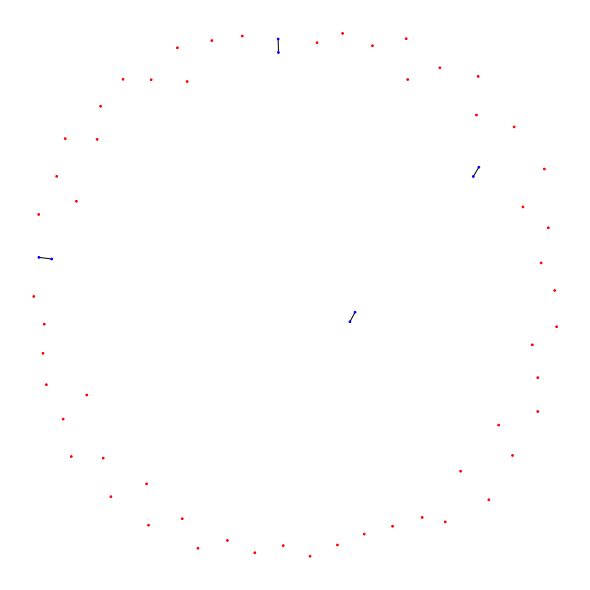

In [34]:
print('##### LCC in PPI #####')
HSN = interactome_processing("BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")
DGA = DGA_processing('curated_gene_disease_associations.tsv', 'Libman-Sacks Disease')
#DG_in_PPI,splits = make_seeds_splits(DGA,HSN)
DG_in_PPI, splits = import_seeds_split()
LCC = extract_LCC_form_PPI(HSN)


print('##### Disease Network #####')
DN = make_disease_graph(HSN, DGA, DG_in_PPI)
plot_LCC(DN, DG_in_PPI)

In [5]:
print(splits)

{0: ['TNFAIP3', 'DNASE1L3', 'RASGRP1', 'TLR5', 'C1QA', 'FCGR2A', 'DNASE1', 'PRDM1', 'CRP', 'HLA-DQA1', 'DEF6'], 1: ['TREX1', 'CR2', 'PTGS2', 'IL21', 'P2RY12', 'BLK', 'ANXA3', 'CFB', 'CSK', 'IL6', 'RASGRP3'], 2: ['CD226', 'SIGLEC6', 'CTLA4', 'CAT', 'IL4', 'IFIH1', 'CLU', 'ITGAM', 'PRL', 'TCF7', 'IL21R'], 3: ['IL10', 'ETS1', 'PTPN22', 'IRF5', 'CLEC16A', 'SLC15A4', 'NCF1', 'FCGR2B', 'IRAK4', 'UHRF1BP1', 'TERT'], 4: ['SH2B3', 'IKZF1', 'IL12B', 'PDCD1', 'HLA-DRB1', 'PXK', 'BANK1', 'SYNGR1', 'TNIP1', 'STAT4', 'JAZF1']}


# 2) Algorithms to be used for the heuristic tasks

In [32]:
def diamond(LCC, seeds, splits):
    
    pairs_genes = list(LCC.edges)
    textfile = open("PPI_Libman.txt", "w")
    for gA, gB in tqdm(pairs_genes):
        textfile.write(str(gA) + ',' + str(gB) + '\n') 
    textfile.close()
    
    '''
    line 317 
    candidates = set(cluster_nodes)
    universe = set()
    for _ in range(0, 2):
        for gene in candidates.copy():
            universe |= neighbors[gene]
            candidates = universe        
    N = len(universe)
    ''' 
    # da implementare for loop che cambia i seed genes secondo gli split pre definiti
    !python3  DIAMOnD/DIAMOnD.py  PPI_Libman.txt  seed_gene.txt  100 #aumentare da 100 a 500
    
    for x in [10,4,2,1]: # possiamo usare direttamente i valori (20,100,200...)
        print(x, evaluation(math.ceil(56/x),x,splits,seeds))

def evaluation(top_n,x,splits,seeds):
    recalls = []
    precs = []
    for i in range(1,11):
        cv = pd.read_csv(f'cross_{i}_result100.txt',sep='\t').DiaBLE_node
        top = set(cv[0:top_n].tolist())
        inters = top.intersection(seeds)
        recall = len(inters)/top_n
        prec = len(inters)/x
        recalls.append(recall)
        precs.append(prec)
    return {'recall':recalls, 'precision':precs}    
    
def MCL(LCC,seeds,splits):
    adj_mat = nx.adjacency_matrix(LCC)
    recalls = []
    precs = []
    for inflation in [i / 10 for i in range(14, 18)]:
        result = mc.run_mcl(adj_mat, inflation=inflation)
        clusters = mc.get_clusters(result)
        #Q = mc.modularity(matrix=result, clusters=clusters)
        for idx in range(0,5):
            test = set(splits[idx])
            training = set(seeds).difference(test)
            positives = set()
            recall = 0
            prec = 0
            for cluster in clusters:
                if len(set(cluster).intersection(training)) != 0:
                    positives = positives.union(cluster)
            inters = test.intersection(positives)
            recall += len(inters)/(len(positives)+10e-10)
            prec += len(inters)/(len(test)+10e-10)
        recalls.append(recall/5)
        precs.append(prec/5)
            
        print("inflation:", inflation,', modularity', ", # clusters:", len(clusters),', max #nodes in cluster:', max([len(cluster) for cluster in clusters]),', mean #nodes in cluster:', statistics.mean([len(cluster) for cluster in clusters]))
    return recalls,precs

## 2.1 MCL 

In [30]:
MCL_rec, MCL_prec = MCL(LCC,DG_in_PPI,splits)

inflation: 1.4 , modularity , # clusters: 159 , max #nodes in cluster: 14772 , mean #nodes in cluster: 123.39622641509433
inflation: 1.5 , modularity , # clusters: 328 , max #nodes in cluster: 8978 , mean #nodes in cluster: 59.81707317073171
inflation: 1.6 , modularity , # clusters: 625 , max #nodes in cluster: 8412 , mean #nodes in cluster: 31.392
inflation: 1.7 , modularity , # clusters: 1180 , max #nodes in cluster: 7148 , mean #nodes in cluster: 16.627118644067796


## 2.2 DIAMOnD/DiaBLE

In [33]:
diamond(LCC, DG_in_PPI,splits)

100%|██████████| 665061/665061 [00:00<00:00, 1627248.25it/s]


DIAMOnD(): ignoring 1 of 1 seed genes that are not in the network
Traceback (most recent call last):
  File "DIAMOnD/DIAMOnD.py", line 451, in <module>
    added_nodes = DIAMOnD(G_original,
  File "DIAMOnD/DIAMOnD.py", line 401, in DIAMOnD
    added_nodes = diamond_iteration_of_first_X_nodes(G_original,
  File "DIAMOnD/DIAMOnD.py", line 347, in diamond_iteration_of_first_X_nodes
    info[next_node][0],
KeyError: 'nix'
10 {'recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
4 {'recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
2 {'recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
1 {'recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


## 2.4 Diffusion-based algorithm 

In [ ]:
def DB_algorithm(seeds)
    precision=[]
    recall=[]
    random.seed(123)
    for i in range(1,11):
        random.shuffle(seeds)
        cross=pd.read_csv('/content/cross {} results.csv'.format(i),sep=',')
        cross=cross[cross['selected']==True]
        cross=cross[cross['diffusion_input']==0]
        cross=cross.sort_values(by='diffusion_output_rank')
        par_prec=[]
        par_rec=[]
        for top in [100,1000,2000]:
            check=set(cross[0:top]['name'].tolist())
            P=len(check.intersection(seeds))
            par_prec.append(P/top)
            par_rec.append(P/56)
        precision.append(par_prec)
        recall.append(par_rec)


print(precision)
print(recall)

[[0.0, 0.001, 0.0005], [0.0, 0.002, 0.001], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0005], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0005], [0.0, 0.0, 0.0005], [0.0, 0.0, 0.0005], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.017857142857142856, 0.017857142857142856], [0.0, 0.03571428571428571, 0.03571428571428571], [0.0, 0.0, 0.0], [0.0, 0.0, 0.017857142857142856], [0.0, 0.0, 0.0], [0.0, 0.0, 0.017857142857142856], [0.0, 0.0, 0.017857142857142856], [0.0, 0.0, 0.017857142857142856], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]


In [ ]:
cross=pd.read_csv('/content/cross 1 results.csv',sep=',')
#cross=cross[cross['selected']==True]
cross=cross[cross['diffusion_input']==0]
cross=cross.sort_values(by='diffusion_output_rank')
a=set(cross[0:19000]['name'].tolist())
a.intersection(seeds)

## 2.5 MOSES (Optional)

Guide: https://wiki.opencog.org/w/Python#MOSES_from_Python

## 2.6 Random Walk with Restart (Optional)

# 3) 10-fold cross validation

# 4) Extended Validation

# 5) EnrichR